## Домашнее задание №1


#### Тема: Языковое моделирование и определение языка.


**Выдана**:   14 сентября 2017

**Дедлайн**:   <font color='red'>9:00 утра 28 сентября 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 3)

#### Правила:

Результат выполнения задания $-$ отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев $-$ тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 3). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе Вам предстоит реализовать n-грамную языковую модель с несколькими видами сглаживания:
- Add-one smoothing
- Stupid backoff
- Interpolation smoothing
- Kneser-Ney smoothing

Вы обучите ее на готовых корпусах, оцените качество и проведете ряд экспериментов. Во второй части задания Вы примените реализованную модель (но с буквенными n-граммами) к задаче распознавания языка. 


# Языковые модели

Цель языкового моделирования заключается в том, чтобы присвоить некоторые вероятности предложениям. Задача состоит в подсчете вероятности $P(W) = P(w_1, \dots, w_n)$ или $P(w_n \mid w_1, \dots, w_{n-1})$. Модель, умеющая вычислять хотя бы одну из этих двух вероятностей, называется **языковой моделью** (LM от Language Model).

Согласно **цепному правилу** (chain rule):

$$P(X_1, \dots, X_n) = P(X_1)P(X_2 \mid X_1)\dots P(X_n \mid X_1, \dots, X_{n-1}).$$ 

Также мы знаем, что

$$
    P(X_n \mid X_1, \dots, X_{n-1}) = \frac{P(X_1, \dots, X_n)}{P(X_1, \dots, X_{n-1})},
$$

следовательно, для того чтобы оценить $P(X_n \mid X_1, \dots, X_{n-1})$ нужно посчитать $P(X_1, \dots, X_n)$ и $P(X_1, \dots, X_{n-1})$. Но эти вероятности будут чрезвычайно малы, если мы возьмем большое $n$, так множество предложений из $n$ слов растет экспоненциально. Для упрощения применим **марковское предположение**: 

$$P(X_n \mid X_1, \dots, X_{n-1}) = P(X_n \mid X_{n - k + 1}, \dots, X_{n-1})$$

для некоторого фиксированного (небольшого) $k$. Это предположение говорит о том, что $X_{n}$ не зависит от $X_{1}, \dots, X_{n - k}$, то есть на следующее слово влияет лишь контекст из предыдущих $k - 1$ слова. Таким образом, мы получаем финальную вероятность:

$$
    P(w_1, \dots, w_n) = \prod_i P(w_i \mid w_{i-k+1}, \dots, w_{i - 1}).
$$

Далее для краткости будем обозначать $w_{i-k}^i := w_{i-k}, \dots, w_{i}$.

## Хранилище n-грам

Для начала выполним вспомогательную работу. Следуйте комментариям, чтобы написать NGramStorage с удобным интерфейсом.

In [1]:
import re
import math
import random
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
class NGramStorage:
    """Storage for ngrams' frequencies.
    
    Args:
        sents (list[list[str]]): List of sentences from which ngram
            frequencies are extracted.
        max_n (int): Upper bound of the length of ngrams.
            For instance if max_n = 2, then storage will store
            0, 1, 2-grams.
            
    Attributes:
        max_n (Readonly(int)): Upper bound of the length of ngrams.
    """
        
    def __init__(self, sents=[], max_n=0):
        self.__max_n = max_n
        self.__ngrams = {i: Counter() for i in range(self.__max_n + 1)}
        # self._ngrams[K] should have the following interface:
        # self._ngrams[K][(w_1, ..., w_K)] = number of times w_1, ..., w_K occured in words
        # self._ngrams[0][()] = number of all words
        
        ### YOUR CODE HERE
        for sent in sents:
            for i in range(self.__max_n + 1):
                self.__ngrams[i].update([tuple(sent[j:j+i])
                                         for j in range(len(sent) - i + 1)])
        ### END YOUR CODE
        
    def add_unk_token(self):
        """Add UNK token to 1-grams."""
        # In order to avoid zero probabilites 
        if self.__max_n == 0 or ('UNK',) in self.__ngrams[1]:
            return
        self.__ngrams[0][()] += 1
        self.__ngrams[1][('UNK', )] = 1
        
    @property
    def max_n(self):
        """Get max_n"""
        return self.__max_n
        
    def __getitem__(self, k):
        """Get dictionary of k-gram frequencies.
        
        Args:
            k (int): length of returning ngrams' frequencies.
            
        Returns:
            Dictionary (in fact Counter) of k-gram frequencies.
        """
        # Cheking the input
        if not isinstance(k, int):
            raise TypeError('k (length of ngrams) must be an integer!')
        if k > self.__max_n:
            raise ValueError('k (length of ngrams) must be less or equal to the maximal length!')
        return self.__ngrams[k]
    
    def __call__(self, ngram):
        """Return frequency of a given ngram.
        
        Args:
            ngram (tuple): ngram for which frequency should be computed.
            
        Returns:
            Frequency (int) of a given ngram.
        """
        # Cheking the input
        if not isinstance(ngram, tuple):
            raise TypeError('ngram must be a tuple!')
        if len(ngram) > self.__max_n:
            raise ValueError('length of ngram must be less or equal to the maximal length!')
        if len(ngram) == 1 and ngram not in self.__ngrams[1]:
            return self.__ngrams[1][('UNK', )]
        return self.__ngrams[len(ngram)][ngram]

## Оценка качества

Скачайте brown корпус, обучите модель и протестируйте на нескольких примерах последовательностей.

In [3]:
import nltk
# Uncomment next row and download brown corpus
# nltk.download()
from nltk.corpus import brown

Приведем все к нижнему регистру и добавим токены начала и конца предложения.

In [4]:
all_sents = list(brown.sents())
all_sents = [['__begin__'] + [word.lower() for word in sent] + ['__end__']
             for sent in all_sents]
random.shuffle(all_sents)
print('Number of all sentences = {}'.format(len(all_sents)))
train_sents = all_sents[:int(0.8 * len(all_sents))]
test_sents = all_sents[int(0.8 * len(all_sents)):]
print('Number of train sentences = {}'.format(len(train_sents)))
print('Number of test sentences = {}'.format(len(test_sents)))

Number of all sentences = 57340
Number of train sentences = 45872
Number of test sentences = 11468


In [5]:
# Create storage of 0, 1, 2, 3-grams
storage = NGramStorage(train_sents, 3)

In [6]:
# It's time to test your code
print(storage(('to', 'be')))
print(storage(('or',)))
print(storage(('not', 'to', 'be')))
print(storage(('somethingweird',)))
print(storage(()))

1359
3349
27
0
1066913


Для численного измерения качества языковой модели определим **перплексию**:

$$
    {\mathbb{P}}(w_1, \dots, w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_i P(w_i \mid w_{i - k}, \dots, w_{i - 1})\right)^{-\frac1N},
$$

Важно, что минимизация перплексии эквивалентна максимизации правдоподобия модели.

Реализуйте функцию по подсчету перплексии. Обратите внимание, что перплексия по корпусу равна произведению вероятностей **всех** предложений в степени $-\frac1N$, где $N -$ суммарная длина всех предложений.

$10^{-50}$ слишком большое значение. Из-за этого перплексия существенно занижается, так как вероятность многих предложений получается меньше $10^{-50}$, и в случае нулевой вероятности не видно "взрыва", хотя по-хорошему перплексия должна уходить в бесконечноть. С одной стороны "взрывы" могут пугать, с а другой они ярко демонстрируют недостатки и проблемы некоторых методов. Поэтому взял $10^{-100}$.

In [7]:
def perplexity(estimator, sents):
    '''Estimate perplexity of the sequence of words using prob_estimator.'''
    ### YOUR CODE HERE
    # Avoid log(0) by replacing zero by 10 ** (-50).
    perp = 0
    N = 0
    for sent in sents:
        perp += np.log(estimator.prob(sent) or 10 ** (-100))
        N += len(sent)
        
    perp /= -N
    perp = np.e ** perp
    
    ### END YOUR CODE
    
    return perp

## Оценка вероятностей n-грам

Первый и простейший способ оценки вероятностей N-грам следующий:

$$
    \hat P_{S}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N)}{c(w_1^{N-1})}.
$$

где $c(w_1^N)$ — это число последовательностей $w_1, \dots, w_N$ в корпусе, $S$ символизирует Straightforward. 

In [8]:
class StraightforwardProbabilityEstimator:
    """Class for simplest probability estimations of type P(word | context).
    
    P(word | context) = c(context + word) / c(context), where
    c(sequence) - number of occurances of the sequence in the corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
    """
    
    def __init__(self, storage):
        self.__storage = storage
        # Adding UNK token to avoid zero probabilities
        self.__storage.add_unk_token()
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if self.__storage.max_n == 1:
            return ()
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('context must be a tuple of strings!')
        for w in context:
            if not isinstance(w, str):
                raise TypeError('context must be a tuple of strings!') 

        # If context is too large, let's cut it.
        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)
        # Avoiding 0 / 0.
        if context_counts == 0:
            return 0
        return phrase_counts / context_counts
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [9]:
# Initialize estimator
simple_estimator = StraightforwardProbabilityEstimator(storage)

# Estimating perplexity
print('Simple estimator perplexity = {}'.format(perplexity(simple_estimator, test_sents)))
print(simple_estimator.prob('to be'.split()))
print(simple_estimator.prob('to be or not to be'.split()))

Simple estimator perplexity = 25010.83835997765
0.001273767145243197
0.0


Здесь как раз можем наблюдать "взрыв" перплексии, который происходит из-за того, что вероятности многих предложений ранва 0. Наш эстиматор весьма примитивен: он не использует никаких сглаживаний, а значит, если какой-то триграмы в корпусе не было, то вероятность всего предложения равна 0.

Посчитаем перплексию униграмной модели.

In [10]:
uni_storage = NGramStorage(train_sents, 1)
uni_simple_estimator = StraightforwardProbabilityEstimator(uni_storage)
print('Simple estimator perplexity = {}'.format(perplexity(uni_simple_estimator, test_sents)))

Simple estimator perplexity = 887.8432346986323


In [11]:
sent = 'to be or not to be'.split()
for i in range(len(sent) + 1):
    trigram = tuple(sent[max(0, i - 3):i])
    print(trigram, storage(tuple(sent[max(0, i - 3):i])))

() 1066914
('to',) 20922
('to', 'be') 1359
('to', 'be', 'or') 1
('be', 'or', 'not') 0
('or', 'not', 'to') 2
('not', 'to', 'be') 27


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Какие выводы можно сделать? Почему $P(\text{To be or not to be}) = 0$, хотя мы и добавили UNK токен?  
**A:** Две триграмы, учавствующие в подсчете вероятности, не встречались в корпусе, поэтому данный эстиматор счиает, что вероятность этого предложнения равна 0. С таким эстиматором при не очень большом корпусе (наш случай) вообще вероятность предложений часто всего будет равна 0, ведь стоит поменять, например, порядок слов в триграме, и она уже может не встретится в таком виде в корпусе и занулит вероятность.

**Q:** Почему перплексия униграмной модели меньше, чем триграмной?  
**A:** В общем-то проблема триграмной модели описана выше. Униграмная модель в этом плане гораздо более мягкая, и, чтобы вероятность предложения не была равна 0, нужно лишь чтобы все слова из него встречались в корпусе. А раз вероятности предложений в униграмной модели больше, значит перплексия меньше.


## Add-one smoothing

Простейший вид сглаживания — **сглаживание Лапласа**. Чтобы избавиться от нулевых вероятностей $P(w_{N} \mid w_1^{N - 1})$, будем использовать формулу:

$$
    \hat P_{AOS}(w_{N} \mid w_1^{N - 1}) = \frac{c(w_1^N) + \delta}{c(w_1^{N-1}) + \delta V},
$$

где $V$ — это размер словаря, а $\delta$ — некоторая фиксированная константа.

Реализуйте класс, осуществляющий сглаживание Лапласа. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [12]:
class LaplaceProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = (c(context + word) + delta) / (c(context) + delta * V), where
    c(sequence) - number of occurances of the sequence in the corpus,
    delta - some constant,
    V - number of different words in corpus.
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): Smoothing parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if len(context) + 1 > self.__storage.max_n:
            return context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('context must be a tuple!')
            
        ### YOUR CODE HERE
        for w in context:
            if not isinstance(w, str):
                raise TypeError('context must be a tuple of strings!') 

        context = self.cut_context(context)
        phrase_counts = self.__storage(context + (word, ))
        context_counts = self.__storage(context)

        return (phrase_counts + self.__delta)/(context_counts + self.__delta * len(self.__storage[1]))
        
        ### END YOUR CODE
            
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

Подберите наилучший параметр $\delta$ для данного корпуса.

Оценим вначале порядок, а потом подберем уже конкретный множитель. Заодно для наглядности можно построить график. На графиках отображена зависимость перплексии от логарифма $\delta$. Собственно, выбираем ту $\delta$, которой соответствует минимальная перплексия.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
def get_perplexity(delta):
    laplace_estimator = LaplaceProbabilityEstimator(storage, delta)
    return perplexity(laplace_estimator, test_sents)


def get_best_delta_from_possible_deltas(possible_deltas):
    perplexities = [get_perplexity(d) for d in possible_deltas]
    plt.plot(np.log10(possible_deltas), perplexities)
    best_index = np.argmin(perplexities)
    return possible_deltas[best_index]

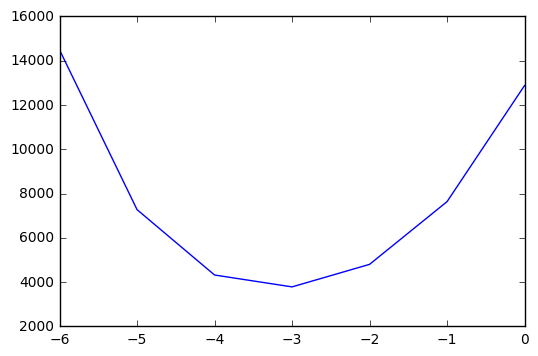

In [15]:
rough_estimate = get_best_delta_from_possible_deltas([10 ** i for i in range(-6,1)])

Если захотите позапускать, но не хотите ждать, лучше уменьшите число вариантов. $20$ вполне достаточно, чтобы получился красивый график :)

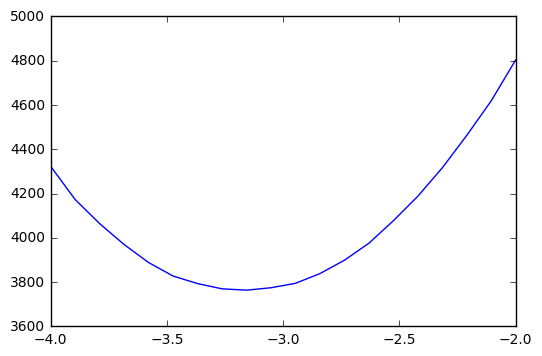

In [16]:
number_of_detailed_variants = 20
variants = np.linspace(np.log10(rough_estimate) - 1,
                       np.log10(rough_estimate) + 1,
                       number_of_detailed_variants)
variants = [10 ** var for var in variants]
best_delta = get_best_delta_from_possible_deltas(variants)

In [17]:
# Try to find out best delta parameter. We will not provide you any strater code.
### YOUR CODE HERE
print('best_delta = ', best_delta)
### END YOUR CODE

# Initialize estimator
laplace_estimator = LaplaceProbabilityEstimator(storage, best_delta)

# Let's make some estimations
print('Laplace estimator perplexity = {}'.format(perplexity(laplace_estimator, test_sents)))
print(laplace_estimator.prob('to be'.split()))

best_delta =  0.000695192796178
Laplace estimator perplexity = 3763.8240385962504
0.00127182878593


Как видно из графиков, действительно есть некоторое оптимальное дельта. Правда результат даже с ним все равно не очень. Но, конечно, лучше, чем в случае простого эстиматора.

## Stupid backoff

Идея **простого отката** довольно понятна. Если у нас есть достаточно информцаии для подсчета вероятности $k$-грам, то будем использовать $k$-грамы. Иначе будем использовать вероятности $(k-1)$-грам с некоторым множителем, например, $0.4$, и так далее. К сожалению, в данном случае мы получим не вероятностное распределение, но в большинстве задач это не имеет принципиального значения. Если это все же важно, то необходимо подобрать множитель соответствующим образом.

Реализуйте класс, симулирующий сглаживание простым откатом. Он должен иметь аналогичный интерфейс, как и StraightforwardProbabilityEstimator.

In [18]:
class StupidBackoffProbabilityEstimator:
    """Class for stupid backoff probability estimations.
    
    P(word | context) =
        P'(word | context),                  if  P'(word | context) > 0;
        P'(word | context[1:]) * multiplier, if  P'(word | context) == 0
                                             and P'(word | context[1:]) > 0;
        ...
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        multiplier (float): Multiplier which is used for probability estimations.
    """
    
    def __init__(self, base_estimator, multiplier=0.1):
        self.__base_estimator = base_estimator
        self.__mult = multiplier
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        
        ### YOUR CODE HERE
        context = self.__base_estimator.cut_context(context)
        prob = self.__base_estimator(word, context)
        ### END YOUR CODE
        
        return prob if prob != 0 else self.__mult*self(word, context[1:]) 
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [19]:
# Initialize estimator
sbackoff_estimator = StupidBackoffProbabilityEstimator(simple_estimator, .4)

# Let's make some estimations
print('Stupid backoff estimator perplexity = {}'.format(perplexity(sbackoff_estimator, test_sents)))
print(sbackoff_estimator.prob('to be'.split()))

Stupid backoff estimator perplexity = 397.04601821612346
0.001273767145243197


Ответьте на следующие вопросы (внутри ipython ноутбука):

**Q:** Почему бессмысленно измерять перплексию в случае **Stupid backoff**?  
**A:** Потому что то, что мы имеем на выходе, не является вероятностным распределением: сумма всех "вероятностей" не даст единицу, она будет больше. Поэтому естественно, что если подставить эти "вероятности" в формулу для перплексии, то мы получем заниженное значение. При чем её нельзя даже использовать для сравнения разных коэффициентов, потому что суммы вероятностей опять же будут отличаться.


## Interpolation smoothing

В данном случае идея сглаживания посредством **интерполяции** также крайне проста. Пусть у нас есть $N$-грамная модель. Заведем вектор $\bar\lambda = (\lambda_1, \dots, \lambda_N)$, такой, что $\sum_i\lambda_i = 1$ и $\lambda_i \geq 0$. Тогда

$$
    \hat P_{IS}(w_{N} \mid w_1^{N-1}) = \sum_{i=1}^N \lambda_i \hat P_{S}(w_N \mid w_{N-i+1}^{N-1}).
$$

Придумайте, как обойтись одним вектором $\bar\lambda$, т.е. пользоваться им как в случае контекста длины $N$, так и при контексте меньшей длины (например, в начале предложения). Если мы просто обрубим сумму, то у нас уже не будет вероятностное распределение, что, конечно же, плохо.

При длине контекста $len(c)$ меньшей $N$ оставим $len(c)$ последних $\lambda$ и отнормируем их к $1$. В этом случае мы вновь получим на выходе вероятностное распределение.

In [20]:
class InterpolationProbabilityEstimator:
    """Class for interpolation probability estimations.
    
    P(word | context) =
        lambda_N * P'(word | context) +
        lambda_{N-1} * P'(word | context[1:]) +
        ... +
        lambda_1 * P'(word)
    P'(word | context) - probability of a word provided context of a base estimator.
    
    Args:
        base_estimator(BaseProbabilityEstimator): Object of BaseProbabilityEstimator
            or some other class which can estimate conditional probabilities.
        lambdas (np.array[float]): Lambdas which are used for probability estimations.
    """
    
    def __init__(self, base_estimator, lambdas):
        self.lambdas = list(reversed(lambdas))
        self.__base_estimator = base_estimator
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        
        ### YOUR CODE HERE
        context = self.__base_estimator.cut_context(context)
        probs = [self.__base_estimator(word, context[i:])
                 for i in range(len(context) + 1)]
            
        lambdas = self.lambdas[:len(context) + 1]
        prob = sum([p * lam for p, lam in zip(probs,
                                              lambdas)])
        prob /= sum(lambdas)

        ### END YOUR CODE
        
        return prob
    
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [21]:
import numpy as np

# Initialize estimator
interpol_estimator = InterpolationProbabilityEstimator(simple_estimator, np.array([0.2, 0.2, 0.6]))

# Let's make some estimations
print('Interpolation estimator perplexity = {}'.format(perplexity(interpol_estimator, test_sents)))
print(interpol_estimator.prob('to be'.split()))

Interpolation estimator perplexity = 471.09793750275594
0.00097884710234


Как видим, перплексия уже значительно лучше. Радует, что улучшения модели действительно работают.

Обучить значения параметров $\lambda$ можно с помощью EM-алгоритма, но мы не будем этого здесь делать.

## Kneser-Ney smoothing

Идея данного сглаживания заключается в том, что словам, которые участвуют в большом количестве контекстов, присваиваются большие вероятности, а те, которые используются в паре-тройке контекстов, получают маленькие вероятности. Формулы приведены на слайде 37 лекции.
Реализуйте данный подход.

Если использовать просто формулы с лекции, то все равно относительно часто вероятность предложений получается 0. <a href="https://web.stanford.edu/~jurafsky/slp3/4.pdf">Вот здесь</a> для решения этой проблемы в оценке вероятности для униграм вводится еще одно константное небольшое слагаемое, отвечающее равномерному распределению. Естественно, для этого из первого слагаемого нужно немного вычесть.

In [22]:
def count_unique_endings(storage):
    def _endings_for_ngrams(n, dictionary):
        unique_endings = {}
        for ngram in storage[n].keys():
            key = ngram[:-1]
            value = ngram[-1]
            if unique_endings.get(key) is None:
                unique_endings[key] = [value]
            else:
                unique_endings[key].append(value)

        for key, value in unique_endings.items():
            dictionary[key] = len(set(value))

    result = {}
    _endings_for_ngrams(2, result)
    _endings_for_ngrams(3, result)
    return result


def count_unique_beginnings(storage):
    unique_beginnings = {}
    for ngram in storage[2].keys():
        key = ngram[1]
        value = ngram[0]
        if unique_beginnings.get(key) is None:
            unique_beginnings[key] = [value]
        else:
            unique_beginnings[key].append(value)
            
    return {key: len(set(value))
            for key, value in unique_beginnings.items()}


def count_ngram_with_countinues(storage):
    def _count_countinues(n, result):
        for ngram, value in storage[n].items():
            key = ngram[:-1]
            if result.get(key) is None:
                result[key] = value
            else:
                result[key] += value
    result = {}
    _count_countinues(2, result)
    _count_countinues(3, result)
    return result

In [23]:
class KneserNeyProbabilityEstimator:
    """Class for probability estimations of type P(word | context).
    
    P(word | context) = ...
    
    Args:
        storage(NGramStorage): Object of NGramStorage class which will
            be used to extract frequencies of ngrams.
        delta(float): KneserNey parameter.
    """
    
    def __init__(self, storage, delta=1.):
        self.__storage = storage
        self.__delta = delta
        self.__counted_endings = count_unique_endings(storage)
        self.__counted_beginnings = count_unique_beginnings(storage)
        self.__counted_ngram_with_countinues = count_ngram_with_countinues(storage)
        # print(list(self.__counted_endings.items())[:100])
        # print(list(self.__counted_beginnings.items())[:100])
        # print(list(self.__counted_bigram_with_countinues.items())[:100])
        
    def cut_context(self, context):
        """Cut context if it is too large.
        
        Args:
            context (tuple[str]): Some sequence of words.
        
        Returns:
            Cutted context (tuple[str]) up to the length of max_n.
        """
        if len(context) + 1 > self.__storage.max_n:
            context = context[-self.__storage.max_n + 1:]
        return context
        
    def __call__(self, word, context):
        """Estimate conditional probability P(word | context).
        
        Args:
            word (str): Current word.
            context (tuple[str]): Context of a word.
            
        Returns:
            Conditional probability (float) P(word | context).
        """
        # Cheking the input
        if not isinstance(word, str):
            raise TypeError('word must be a string!')
        if not isinstance(context, tuple):
            raise TypeError('word must be a string!')
        # If context is too large, let's cut it.
        context = self.cut_context(context)
        
        ### YOUR CODE HERE
        if len(context) > 0:
            denominator = self.__counted_ngram_with_countinues.setdefault(context, 0)
            if denominator == 0:
                return self(word, context[1:])
            unique_continued = self.__counted_endings.setdefault(context, 0)
            return (max(self.__storage(context + (word,)) - self.__delta, 0) / denominator +
                    self.__delta / denominator * unique_continued * self(word, context[1:]))
        else:
            uniform = self.__delta / self.__storage(())
            unique_begin = self.__counted_beginnings.setdefault(word, 0)
            return max(unique_begin - self.__delta, 0) / len(self.__storage[2]) + uniform
        ### END YOUR CODE
            
    def prob(self, sent):
        """Estimate probability of a sentence using Markov rule.
        
        Args:
            sentence (list[str]): Sentence for probability estimation.
            
        Returns:
            Probability (float) P(sentence).
        """
        prob = 1.
        for i in range(len(sent)):
            prob *= self(sent[i], tuple(sent[:i]))
        return prob

In [24]:
# Initialize estimator
kn_estimator = KneserNeyProbabilityEstimator(storage)
# Estimating perplexity
print('KN estimator perplexity = {}'.format(perplexity(kn_estimator, test_sents)))
print(kn_estimator.prob('to be'.split()))
print(kn_estimator.prob('to be or not to be'.split()))

KN estimator perplexity = 521.741439540655
0.0007989387936916641
8.197844594661268e-11


Здесь перплексия получилась чуть больше, чем в случае интерполяционного эстиматора, но разница не настолько велика, чтобы однозначно говорить о том, какой из этих методов лучше. Зато видно, что оба они значительно лучше более наивных методов.

## Определение языка документа

**Постановка задачи:**  
Одна из задач, которая может быть решена при помощи языковых моделей $-$ **определение языка документа**. Реализуйте два классификатора для определения языка документа:
1. Наивный классификатор, который будет учитывать частоты символов и выбирать язык текста по признаку: распределение частот символов "наиболее похоже" на распределение частот символов в выбранном языке.
2. Классификатор на основе языковых моделей. Сами придумайте, как он должен работать.  
_Подсказка_: лучше считать n-грамы не по словам, а по символам.

---

**Как представлены данные:**  
Во всех текстовых файлах на каждой строчке записано отдельное предложение.
1. В папке _data_ находятся две папки: _full_ и _plain_. В _full_ находятся тексты в той форме, что они были взяты из сети, в _plain_ находятся те же самые тексты, но с них сначала была снята диакритика, а затем русский и греческий тексты были транслитерованы в английский.
2. В каждой из папок _full_ и _plain_ находятся папки _train_ и _test_.
3. В _train_ находятся файлы с текстами с говорящими именами, например, _ru.txt_, _en.txt_.
4. В _test_ находятся файлы _1.txt_, _2.txt_, $\dots$ в которых хранятся тексты, язык которых нужно определить. В этой же папке находится файл _ans.csv_, в котором вы можете найти правильные ответы и проверить, насколько хорошо сработали Ваши алгоритмы.

---

**Что нужно сделать:**  
Напишите два своих классификатора (которые описаны в постановке задачи) и получите максимально возможное accuracy на test-сете. Разрешается использовать только _train_ для обучения.

---

**В данном задании мы не предоставляем стартового кода!**

In [53]:
import os
import pandas as pd

Считываем данные

In [54]:
def get_file_names(path, extension='txt'):
    return [file_name for file_name in os.listdir(path)
            if file_name.split('.')[-1] == extension]

def get_texts(dir_path, file_names, row=False):
    def prepare_doc(name, row=False):
        if row:
            return open(dir_path + name, 'r').read().lower()
        else:
            return [['__begin__'] + list(word) + ['__end__']
                    for word in open(dir_path + name, 'r').read().lower().split()]

    return [prepare_doc(name, row)
            for name in file_names]

extension = 'txt'
path_train = './plain/train/'
path_test = './plain/test/'
ans_file = 'ans.csv'

doc_names_train = get_file_names(path_train)
doc_names_test = list(sorted(get_file_names(path_test),
                             key=lambda name: int(name.split('.')[0])))

train = get_texts(path_train, doc_names_train)
test = get_texts(path_test, doc_names_test)
train_row = get_texts(path_train, doc_names_train, True)
test_row = get_texts(path_test, doc_names_test, True)


languages = [file_name.split('.')[0]
             for file_name in doc_names_train]

answers = pd.read_csv(path_test + ans_file, header=None).values.T[1]

Как у меня работает наивный классификатор?  
При обучении он составит Counter для каждого из языков.  
При классификации он считает ошибку в виде суммы квадратов разностей частотов символов в посчитаных на этапе обучения Counter'ах и частот в Counter'е классифицируемого текста. Выбирать будем тот язык, ошибка для которого получилась наименьшей.

In [55]:
class NaiveClassifier:
    def __init__(self, train, languages):
        self.languages = languages
        self.counters = [Counter(text) for text in train]
        for counter, text in zip(self.counters, train):
            self._to_freq(counter, len(text))
        
    @staticmethod
    def _to_freq(counter, lenght):
        for key in counter.keys():
            counter[key] /= lenght
            
    @staticmethod
    def _error(counter1, counter2):
        error = 0
        all_keys = set(list(counter1.keys()) + list(counter2.keys()))
        for key in all_keys:
            error += (counter1[key] - counter2[key])**2
        return error
            
    def __call__(self, test):
        test_counter = Counter(test)
        self._to_freq(test_counter, len(test))
        errors = [self._error(train_counter, test_counter)
                  for train_counter in self.counters]
        best_index = np.argmin(errors)
        return self.languages[best_index]

In [56]:
classifier = NaiveClassifier(train_row, languages)

In [57]:
def get_accuracy(classifier, test_data, answers):
    return len([1 for text, ans in zip(test_data, answers)
                if classifier(text) == ans]) / len(answers)


def print_mistakes(classifier, test_data, answers, print_limit=10):
    mistakes = 0
    for i, (text, ans) in enumerate(zip(test_row[:50], answers[:50])):
        my_ans = classifier(text)
        if my_ans != ans and mistakes < 10:
            print(i, 'right: ', ans, 'my: ', my_ans)
            mistakes += 1

In [58]:
get_accuracy(classifier, test_row, answers)

0.9958333333333333

In [59]:
print_mistakes(classifier, test_row, answers)

45 right:  en my:  de


Что ж, такой, весьма простой, подход показал прекрасный результат: всего одна ошибка из 240 тестов.

Теперь реализуем классификатор работающий на языковых моделях. Он с учетом уже разработанного функционала работает довольно просто.  
На трейне инициализируем для каждого языка свою модель.  
Классифицировать будем следующим образом: посчитаем перплексию на тестовом тексте для каждой из языковых моделей, инициализированных на стадии трейна, а затем выберем язык, которому соответствует наименьшая перплексия.

In [60]:
class LanguageModelClassifier:
    def __init__(self, train, languages, model_class, gram_lenght=3):
        self.languages = languages
        self.models = [model_class(NGramStorage(text, gram_lenght))
                       for text in train]
        
    def __call__(self, text):
        perplexities = [perplexity(model, text) for model in self.models]
        best_ind = np.argmin(perplexities)
        return self.languages[best_ind]

In [61]:
def get_interpolation_model(storage):
    simple_estimator = StraightforwardProbabilityEstimator(storage)
    return InterpolationProbabilityEstimator(simple_estimator,
                                             np.array([0.2, 0.2, 0.6]))

Давайте попробудем взять для классификации две лучшие языковые модели: интерполяционную и Kneser Nay.

Это будет не быстро

In [62]:
classifier_inter = LanguageModelClassifier(train, languages,
                                           get_interpolation_model)

In [63]:
get_accuracy(classifier_inter, test, answers)

1.0

Это тоже не быстро

In [64]:
classifier_KN = LanguageModelClassifier(train, languages, KneserNeyProbabilityEstimator)

In [65]:
get_accuracy(classifier_KN, test, answers)

1.0

В обоих случах классификатор отработал без ошибок. Зато работает эта прелесть существенно дольше, чем простой частотный классификатор, который показал почти идеальный результат. Так что если не нужен прям сверх точный результат, но зато нужна производительность, то стоит задуматься, прежде чем кидаться пилить языковую модель. В общем-то, как и везде, главное - подходить с умом к задаче :)